### Import

In [49]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

### Parameters

In [50]:
np.random.seed(20)
no_samples = 1500

### Create Different Datasets for testing

In [51]:
noisy_circles = datasets.make_circles(n_samples=no_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=no_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=no_samples)
no_structure = np.random.rand(no_samples, 2), None
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X, y = datasets.make_blobs(n_samples=no_samples)
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
varied = datasets.make_blobs(n_samples=no_samples, cluster_std=[1.0, 2.5, 0.5])

###  Setup Cluster Algorithm Parameters

In [52]:
outputs = []
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "pref": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (noisy_circles,{"damping": 0.77,"pref": -240,"quantile": 0.2,"n_clusters": 2,"min_samples": 20,"xi": 0.25}),
    (noisy_moons, {"damping": 0.75, "pref": -220, "n_clusters": 2}),
    (varied,{"eps": 0.18,"n_neighbors": 2,"min_samples": 5,"xi": 0.035,"min_cluster_size": 0.2}),
    (aniso,{"eps": 0.15,"n_neighbors": 2,"min_samples": 20,"xi": 0.1,"min_cluster_size": 0.2}),
    (blobs, {}),
    (no_structure, {})]

### Run Algorithms

In [53]:
for i, (dataset, algo_params) in enumerate(datasets):

    #Parameters
    params = default_base.copy()
    params.update(algo_params)

    #Get Data
    X, y = dataset

    #Normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    #Estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    #Connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params["n_neighbors"], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    #Create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(n_clusters=params["n_clusters"],
                                           linkage="ward", 
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=params["n_clusters"],
                                          eigen_solver="arpack",
                                          affinity="nearest_neighbors",)
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(min_samples=params["min_samples"],
                            xi=params["xi"],min_cluster_size=params["min_cluster_size"])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["pref"],random_state=0)
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",affinity="cityblock",
        n_clusters=params["n_clusters"],connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(n_components=params["n_clusters"], covariance_type="full")    
    
    #Clustering Algorithms
    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm))    

    #Run Algorithms
    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        outputs.append((algorithm,X,name))
        t1 = time.time()

### Visualize

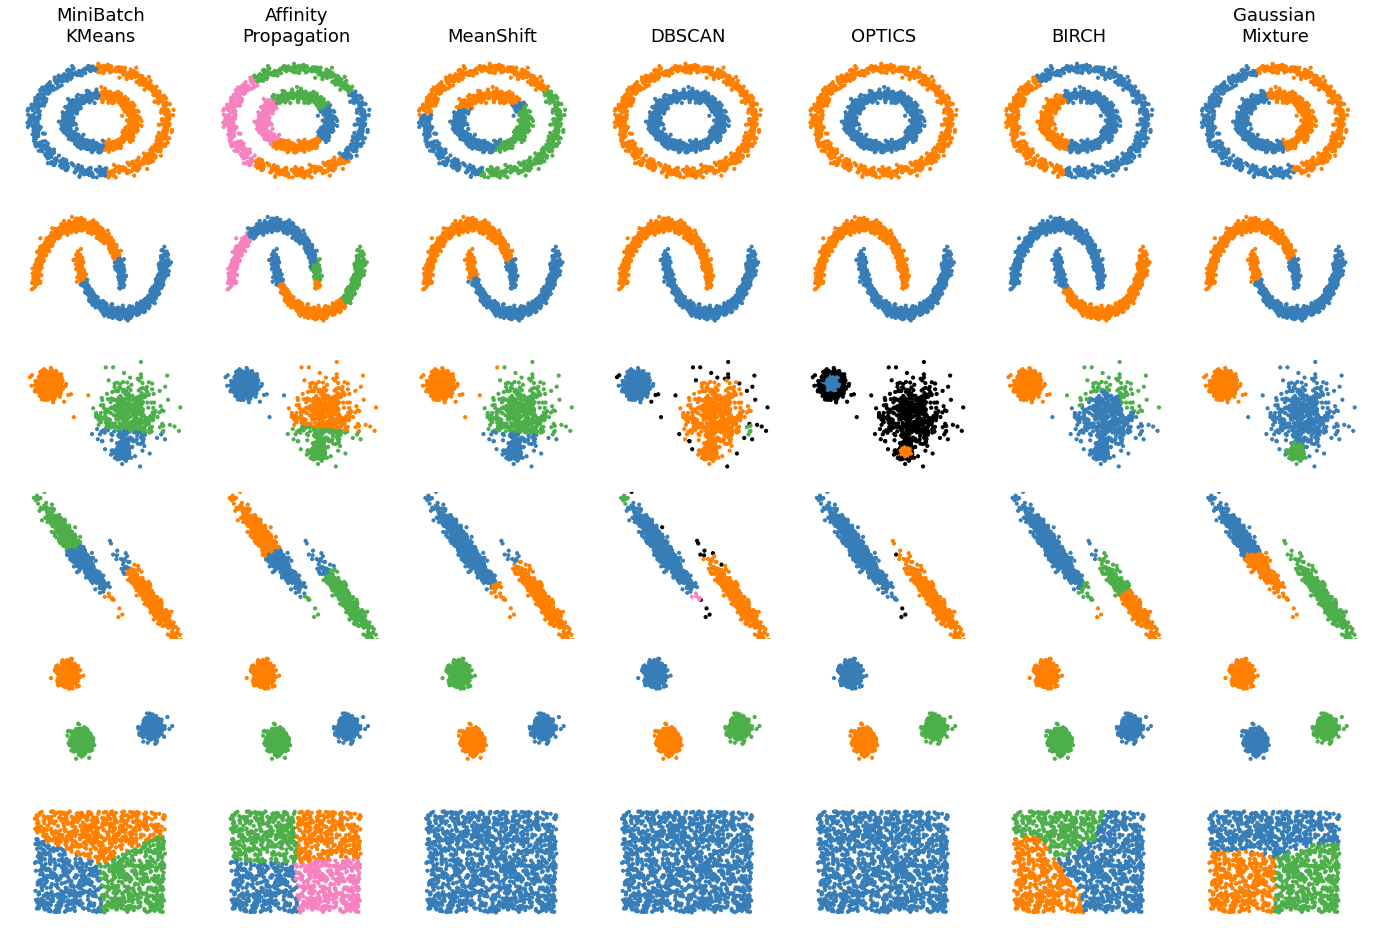

In [64]:
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)
plot_num = 0
for (algorithm,X,name) in outputs:
    plt.subplot(len(datasets), len(clustering_algorithms), plot_num+1)
    if plot_num < 7: plt.title(name, size=18)
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)
    colors = np.array(list(islice(cycle([
        "#377eb8","#ff7f00","#4daf4a",
        "#f781bf","#a65628","#984ea3",
        "#999999","#e41a1c","#dede00",]),int(max(y_pred) + 1),)))
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
    plot_num += 1
plt.savefig('../../assets/figures/clustering_various.png');    